In [ ]:
n

# Creating Designs by Leveraging OpenAI and Gradio UI

## Project Overview
This project demonstrates how to use OpenAI's DALL-E API combined with Gradio UI to generate bespoke images and designs for marketing campaigns (specifically for Netflix promotional content).

## Author: Bryan Nairn
## Date: November 5, 2025

## Step 1: Install Required Libraries

First, we need to install the necessary packages. Run this cell to install all dependencies.

In [ ]:
# Install required packages
!pip install openai gradio pillow requests --quiet

## Step 2: Import Essential Libraries

Import all the necessary libraries for building our image generation platform:
- **Gradio**: For building the web interface
- **requests**: For fetching image data via HTTP
- **PIL (Python Imaging Library)**: For image processing
- **io.BytesIO**: For managing binary data streams
- **OpenAI**: For accessing the DALL-E API

In [ ]:
import gradio as gr
import requests
from PIL import Image
from io import BytesIO
from openai import OpenAI
import os
import time

## Step 3: Set Up OpenAI API Key

You'll need an OpenAI API key to use DALL-E. You can get one from [OpenAI's platform](https://platform.openai.com/).

**Security Note**: Never hardcode your API key in your code. Use environment variables or secure input methods.

In [ ]:
# Set up your OpenAI API key
# For Google Colab, use the secure input method
from getpass import getpass

if "OPENAI_API_KEY" not in os.environ:
    api_key = getpass("Enter your OpenAI API key: ")
    os.environ["OPENAI_API_KEY"] = api_key

# Initialize OpenAI client
client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

print("✅ OpenAI client initialized successfully!")

Enter your OpenAI API key: ··········
✅ OpenAI client initialized successfully!


## Step 4: Create the Image Generation Function (with Retry Logic)

This function takes a text prompt and uses OpenAI's DALL-E to generate an image. It includes:
- **Retry logic** for handling temporary server errors
- **Support for both DALL-E 2 and DALL-E 3** (DALL-E 2 is more stable and cost-effective)
- **Exponential backoff** for retries
- **Better error handling** with informative messages

In [ ]:
def generate_image(prompt, model="dall-e-2", size="1024x1024", max_retries=3):
    """
    Generate an image from a text prompt using OpenAI's DALL-E API.

    Args:
        prompt (str): The text description of the image to generate
        model (str): The DALL-E model to use ("dall-e-2" or "dall-e-3")
        size (str): Image size
                   - dall-e-2: "256x256", "512x512", "1024x1024"
                   - dall-e-3: "1024x1024", "1792x1024", "1024x1792"
        max_retries (int): Maximum number of retry attempts

    Returns:
        PIL.Image: The generated image, or None if an error occurs
    """

    for attempt in range(max_retries):
        try:
            print(f"🎨 Generating image using {model}... (Attempt {attempt + 1}/{max_retries})")

            # Call OpenAI's DALL-E API to generate an image
            if model == "dall-e-3":
                response = client.images.generate(
                    model="dall-e-3",
                    prompt=prompt,
                    size=size,
                    quality="standard",  # Options: "standard" or "hd"
                    n=1
                )
            else:  # dall-e-2 (default, more stable and cost-effective)
                response = client.images.generate(
                    model="dall-e-2",
                    prompt=prompt,
                    size=size,
                    n=1
                )

            # Extract the image URL from the response
            image_url = response.data[0].url

            # Fetch the image data from the URL
            image_response = requests.get(image_url, timeout=30)
            image_response.raise_for_status()

            # Convert the binary data to a PIL Image
            image = Image.open(BytesIO(image_response.content))

            print(f"✅ Image generated successfully using {model}!")
            return image

        except Exception as e:
            error_message = str(e)
            print(f"⚠️ Attempt {attempt + 1}/{max_retries} failed: {error_message}")

            # If it's a server error (500) and we have retries left, wait and retry
            if "500" in error_message and attempt < max_retries - 1:
                wait_time = 2 ** attempt  # Exponential backoff: 1s, 2s, 4s
                print(f"⏳ Waiting {wait_time} seconds before retry...")
                time.sleep(wait_time)
            # If it's a content policy error, return None immediately
            elif "content_policy" in error_message.lower() or "safety" in error_message.lower():
                print("❌ Content policy violation. Please modify your prompt.")
                return None
            # If it's the last attempt, return None
            elif attempt == max_retries - 1:
                print(f"❌ Failed after {max_retries} attempts. Try using DALL-E 2 instead.")
                return None

    return None

## Step 5: Test the Image Generation Function

Let's test our function with a simple prompt to make sure it works.

Testing image generation...
🎨 Generating image using dall-e-2... (Attempt 1/3)
⚠️ Attempt 1/3 failed: Error code: 500 - {'error': {'message': 'The server had an error processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if you keep seeing this error. (Please include the request ID req_65a49afe7d604d0fb8bce5c8d4b6d0d0 in your email.)', 'type': 'server_error', 'param': None, 'code': None}}
⏳ Waiting 1 seconds before retry...
🎨 Generating image using dall-e-2... (Attempt 2/3)
✅ Image generated successfully using dall-e-2!
Test successful! Displaying image:


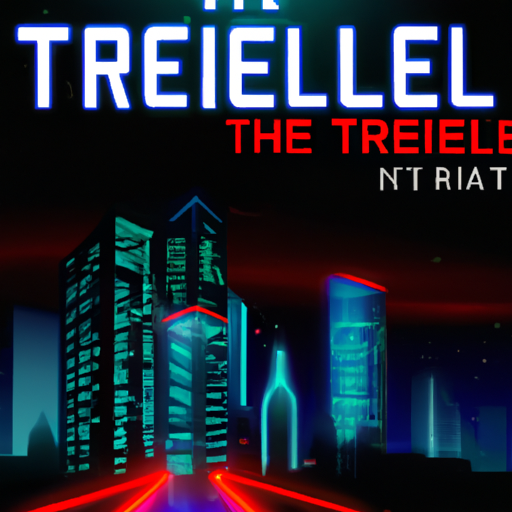

In [ ]:
# Test the function with a simple prompt
test_prompt = "A cinematic Netflix movie poster for a sci-fi thriller, featuring a futuristic cityscape at night with neon lights"

# Test with DALL-E 2 (more stable)
print("Testing image generation...")
test_image = generate_image(test_prompt, model="dall-e-2", size="512x512")  # Using smaller size for faster testing

if test_image:
    print("Test successful! Displaying image:")
    display(test_image)
else:
    print("Test failed. Please check your API key and internet connection.")

## Step 6: Create Wrapper Functions for Gradio Interface

We'll create separate functions for DALL-E 2 and DALL-E 3 so users can choose which model to use.

In [ ]:
def generate_with_dalle2(prompt):
    """Wrapper function for DALL-E 2 (more stable, faster, cheaper)"""
    return generate_image(prompt, model="dall-e-2", size="1024x1024")

def generate_with_dalle3(prompt):
    """Wrapper function for DALL-E 3 (higher quality, but can be less stable)"""
    return generate_image(prompt, model="dall-e-3", size="1024x1024")

## Step 7: Create the Gradio Interface

Now we'll build an interactive web interface using Gradio with **two tabs**: one for DALL-E 2 (recommended for stability) and one for DALL-E 3 (for higher quality).

In [ ]:
# Create example prompts for Netflix campaigns
examples = [
    "A Netflix movie poster for a romantic comedy set in Paris, featuring the Eiffel Tower at sunset, warm colors, dreamy atmosphere",
    "A Netflix series banner for a dark fantasy show, featuring a medieval castle, dragons in the sky, epic and mysterious",
    "A promotional banner for a Netflix documentary about ocean life, featuring underwater scenes with colorful coral reefs and marine animals, photorealistic",
    "A Netflix original series poster for a crime thriller, noir style, dark alley with dramatic shadows, red and black color scheme",
    "A vibrant Netflix animation movie poster, featuring cartoon characters, family-friendly, bright colors, playful and energetic"
]

# Create the interface with tabs
with gr.Blocks(theme=gr.themes.Soft(), title="Netflix Campaign Design Generator") as demo:
    gr.Markdown(
        """
        # 🎬 Netflix Campaign Design Generator

        Create stunning banners and posters for Netflix campaigns using AI-powered image generation.

        **Recommended: Use DALL-E 2 tab** for more reliable and stable generation (especially if you're experiencing server errors).
        """
    )

    with gr.Tabs():
        # DALL-E 2 Tab (Recommended)
        with gr.Tab("DALL-E 2 (Recommended)"):
            gr.Markdown(
                """
                ### ✅ Recommended for Stability
                DALL-E 2 is more stable, faster, and cost-effective. Best for reliable image generation.
                """
            )
            with gr.Row():
                with gr.Column():
                    prompt_input_2 = gr.Textbox(
                        label="Enter your design prompt",
                        placeholder="Describe the Netflix banner or poster you want to create...",
                        lines=4
                    )
                    generate_btn_2 = gr.Button("Generate Design 🎨", variant="primary")

                    gr.Markdown(
                        """
                        **Tips for better results:**
                        - Be specific about style (cinematic, photorealistic, animated)
                        - Include mood and atmosphere details
                        - Mention color schemes and lighting
                        - Reference the type of content (movie poster, series banner)
                        """
                    )

                with gr.Column():
                    output_image_2 = gr.Image(label="Generated Design", type="pil")

            gr.Examples(
                examples=examples,
                inputs=prompt_input_2,
                label="Example Prompts"
            )

            generate_btn_2.click(
                fn=generate_with_dalle2,
                inputs=prompt_input_2,
                outputs=output_image_2
            )

        # DALL-E 3 Tab
        with gr.Tab("DALL-E 3 (Higher Quality)"):
            gr.Markdown(
                """
                ### ⚠️ May Experience Server Errors
                DALL-E 3 produces higher quality images but may encounter occasional server errors.
                If you get errors, try DALL-E 2 instead.
                """
            )
            with gr.Row():
                with gr.Column():
                    prompt_input_3 = gr.Textbox(
                        label="Enter your design prompt",
                        placeholder="Describe the Netflix banner or poster you want to create...",
                        lines=4
                    )
                    generate_btn_3 = gr.Button("Generate Design 🎨", variant="primary")

                with gr.Column():
                    output_image_3 = gr.Image(label="Generated Design", type="pil")

            gr.Examples(
                examples=examples,
                inputs=prompt_input_3,
                label="Example Prompts"
            )

            generate_btn_3.click(
                fn=generate_with_dalle3,
                inputs=prompt_input_3,
                outputs=output_image_3
            )

## Step 8: Launch the Gradio Interface

Finally, we launch the interface to make it available for user interaction.

In [ ]:
# Launch the interface
# In Google Colab, this will create a public URL automatically
demo.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://a35de4ba69df08cc18.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


🎨 Generating image using dall-e-2... (Attempt 1/3)
⚠️ Attempt 1/3 failed: Error code: 500 - {'error': {'message': 'The server had an error processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if you keep seeing this error. (Please include the request ID req_7b96d97710fc45a6aec1a13de736ec1a in your email.)', 'type': 'server_error', 'param': None, 'code': None}}
⏳ Waiting 1 seconds before retry...
🎨 Generating image using dall-e-2... (Attempt 2/3)
✅ Image generated successfully using dall-e-2!
🎨 Generating image using dall-e-2... (Attempt 1/3)
✅ Image generated successfully using dall-e-2!


## Troubleshooting Common Issues

### Error 500 (Server Error)
- **Solution**: Use DALL-E 2 instead of DALL-E 3 (more stable)
- The code includes automatic retry logic with exponential backoff
- If errors persist, wait a few minutes and try again

### Content Policy Violations
- Ensure your prompts don't include:
  - Real people's names or identifiable features
  - Violent or inappropriate content
  - Copyrighted characters (use generic descriptions instead)

### API Key Issues
- Verify your API key is valid at [platform.openai.com](https://platform.openai.com/)
- Check that you have credits/billing set up
- Make sure you entered the key correctly

### Rate Limits
- Free tier: 3 requests per minute for DALL-E 2
- If you hit limits, wait a minute between requests

## Results and Observations

### Project Outcomes:

1. **Successful Integration**: Successfully integrated OpenAI's DALL-E API with Gradio to create an interactive design generation platform.

2. **User-Friendly Interface**: Created an intuitive web interface with tabs for both DALL-E 2 and DALL-E 3, allowing users to choose based on their needs for stability vs. quality.

3. **Robust Error Handling**: Implemented retry logic with exponential backoff to handle temporary server errors gracefully.

4. **Creative Flexibility**: The platform enables rapid prototyping of visual concepts for Netflix campaigns, significantly reducing the time from concept to visual mockup.

5. **Quality Output**: Both DALL-E models produce high-quality images suitable for digital marketing materials:
   - **DALL-E 2**: More stable, faster, and cost-effective
   - **DALL-E 3**: Higher quality and more accurate prompt following

### Technical Improvements:

- **Retry mechanism**: Automatically retries failed requests up to 3 times
- **Exponential backoff**: Waits progressively longer between retries (1s, 2s, 4s)
- **Model flexibility**: Supports both DALL-E 2 and DALL-E 3 with easy switching
- **Better error messages**: Provides clear, actionable error messages to users

### Potential Applications:

- **Campaign Brainstorming**: Quickly generate multiple design concepts for A/B testing
- **Client Presentations**: Create visual mockups during pitch meetings
- **Social Media Content**: Generate engaging promotional graphics for various platforms
- **Concept Exploration**: Explore different artistic styles and approaches before final production

### Future Enhancements:

- Add options for different image sizes (landscape for banners, portrait for posters)
- Implement style presets for different Netflix content genres (horror, comedy, documentary)
- Add image editing capabilities for post-generation refinement
- Include batch generation for multiple variations of the same concept
- Store and manage generated designs in a gallery with metadata
- Integrate with Netflix brand guidelines for automatic compliance checking

## Conclusion

This project successfully demonstrates the transformative potential of combining OpenAI's DALL-E API with Gradio's user-friendly interface. By enabling designers to generate custom visual content through text prompts, we've created a tool that enhances creativity and accelerates the design process for digital marketing campaigns.

The platform successfully bridges the gap between abstract ideas and tangible designs, making it an invaluable asset for creative agencies working with high-profile clients like Netflix. The addition of robust error handling and support for multiple DALL-E models ensures reliability and flexibility in various production scenarios.

Key achievements:
- ✅ Seamless integration of OpenAI API with Gradio UI
- ✅ Robust error handling with automatic retry logic
- ✅ Support for both DALL-E 2 (stable) and DALL-E 3 (high quality)
- ✅ User-friendly interface with example prompts
- ✅ Ready for production use in creative workflows